# Prelude

# Acknowledgements

# Code Starts Here

Libraries that I used

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.animation as animation
import cv2
import scipy as sp
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter
from scipy.ndimage import generate_binary_structure, binary_erosion

## The functions that I made and what they do

In [51]:
def make_corrugated(f, theta):
    x = np.linspace(-1,1,256)
    y = np.linspace(-1,1,256)
    X,Y = np.meshgrid(x,y)
    Z = np.sin(2*np.pi*f*(Y*np.sin(theta) + X*np.cos(theta)))
    return Z

image_repository  = "./Images/"

In [52]:
def show_fft(A, title, mean_center = False):
    # Applying fft
    if mean_center == True:
        A = A  - np.mean(A)
    FA = abs(np.fft.ifft2(A))
    
    # Shifting 
    FAshifted = np.fft.fftshift(FA)
    
    # Plotting
    fig, ax = plt.subplots(1,4, figsize = (20,5))
    ax[0].imshow(A, cmap = "gray")
    ax[0].set_title(title)
    
    ax[1].imshow(FA, cmap = "jet")
    ax[1].set_title("Fourier Transform", pad = 10)
    
    ax[2].imshow(FAshifted, cmap = "jet")
    ax[2].set_title("Shifted Fourier Transform", pad = 10)
    
    ax[3].imshow(np.log(FAshifted), cmap = "jet")
    ax[3].set_title("[Log scale] Shifted Fourier Transform", pad = 10)
    plt.tight_layout()
    plt.show()

In [53]:
def convert_gs(filename, binary = False, invert = False, threshold = 0.3):
    image = Image.open(image_repository + filename)
    gs_image = np.array(image.convert('L'))
    
    if binary == True:
        gs_image = (gs_image - np.min(gs_image))/(np.max(gs_image) - np.min(gs_image))
        gs_image[gs_image > threshold] = 1
        gs_image[gs_image <= threshold] = 0
        
        
    if binary == True and invert == True:
        gs_image = gs_image - 1
        gs_image = gs_image*(-1)
        
        
    if binary == False and invert == True:
        print("lmao cant do that.")
    return gs_image

In [54]:
def fft_animation(num_frames):
    fig, ax = plt.subplots(1,3,figsize = (15,6))

    def update(frame):
        f = 2*np.pi*frame/50
        theta = np.pi*frame/50
        A = make_corrugated(f, theta)

        # Applying fft
        FA = abs(np.fft.ifft2(A))
    
        # Shifting 
        FAshifted = np.fft.fftshift(FA)

        fig.suptitle("2D sinusoid with $\omega$ = " + str(np.round(f, 3)) + " rad/s and θ = " +str(np.round(theta, 3))+ " rad", fontsize=16)

        ax[0].clear()
        ax[1].clear()
        ax[2].clear()


        ax[0].imshow(A, cmap = "gray")
        ax[0].set_title("Sinusoid")
        
        ax[1].imshow(abs(FAshifted), cmap = "jet")
        ax[1].set_title("FFT")

        ax[2].imshow(np.log(abs(FAshifted)), cmap = "jet")
        ax[2].set_title("[LOG SCALE] FFT")

    ani2 = animation.FuncAnimation(fig, update, frames = num_frames, interval=10, blit=False, repeat=False)
    writergif = animation.PillowWriter(fps=60)
    ani2.save("increasing.gif",writer=writergif)
    plt.close()
    

## Outputs

#### Creating sinusoids

In [55]:
# fft_animation(200)

#### Masking

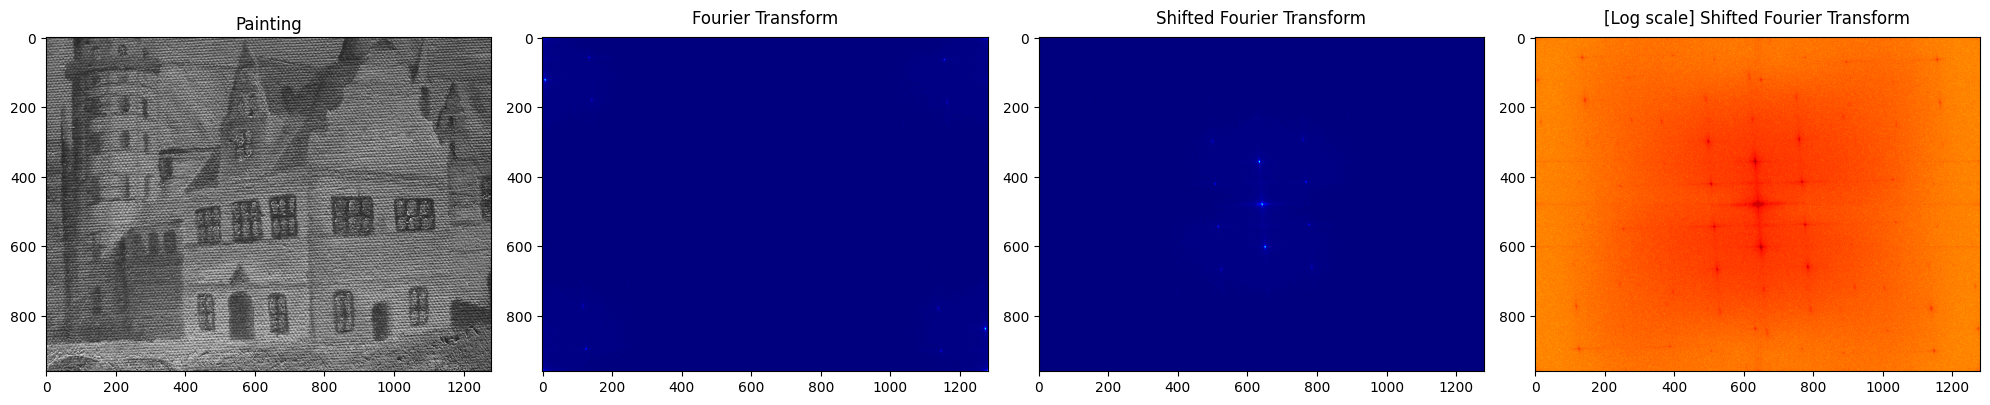

In [56]:
show_fft(convert_gs("185-8526_IMG.JPG"), "Painting", mean_center = True)

#### Masking

In [133]:
def masking(filename, mask):
    image = np.array(Image.open(image_repository + filename))
    mask_shifted = np.fft.fftshift(mask)

    masked = np.zeros(image.shape)
    masked_R= np.fft.fft2(image[..., 0])*mask_shifted
    masked_G = np.fft.fft2(image[..., 1])*mask_shifted
    masked_B = np.fft.fft2(image[..., 2])*mask_shifted

    inv_R = abs(np.fft.ifft2(masked_R))
    inv_G = abs(np.fft.ifft2(masked_G))
    inv_B = abs(np.fft.ifft2(masked_B))

    #Normalizing values
    norm_inv_R = (inv_R - np.min(inv_R))/(np.max(inv_R) - np.min(inv_R))
    norm_inv_G = (inv_G - np.min(inv_G))/(np.max(inv_G) - np.min(inv_G))
    norm_inv_B = (inv_B - np.min(inv_B))/(np.max(inv_B) - np.min(inv_B))

    masked[..., 0] = norm_inv_R
    masked[..., 1] = norm_inv_G
    masked[..., 2] = norm_inv_B


    #plotting
    fig, ax = plt.subplots(1,3, figsize = (15,5))
    ax[0].imshow(image)
    ax[0].set_title("Image")

    ax[1].imshow(mask, cmap = "gray")
    ax[1].set_title("Mask")

    ax[2].imshow(masked)
    ax[2].set_title("Masked Image")

    plt.show()

def make_square(xc, yc, shape):
    x = np.arange(0, shape[1], 1)
    y = np.arange(0, shape[0], 1)
    X,Y = np.meshgrid(x,y)
    A = np.zeros(shape)
    side_l = 10
    A[X < xc - side_l] = 1
    A[X > xc + side_l] = 1
    A[Y > yc + side_l] = 1
    A[Y < yc - side_l] = 1
    return A


def automate_mask(filename, invert = False):

    # Converting to grayscale 
    image = Image.open(image_repository + filename)
    gs_image = np.array(image.convert('L'))
    

    # mean centering and FFT
    A = gs_image - np.mean(gs_image)
    FA = np.fft.fft2(A)
    log_FAshifted = np.log(np.fft.fftshift(abs(FA)))

    # Getting the local maxima and creating a mask out of it
    neighborhood = np.tile(True, (30,30))
    local_max = maximum_filter(log_FAshifted, footprint=neighborhood)==log_FAshifted
    background = (log_FAshifted==0)

    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    detected_peaks = np.array(local_max ^ eroded_background)

    mask = np.ones(gs_image.shape)
    mask[detected_peaks == 0] = 0

    # Dilating the maxima in the mask so that it covers a bigger area
    kernel = np.ones((10, 10))
    mask = cv2.dilate(mask, kernel, iterations=1)

    # makes the mask such that everything is 1 except for the peaks
    if invert == False:
        mask[mask != 0] = 1
        mask = mask - 1
        mask = mask*(-1)
        mask[make_square(int(gs_image.shape[1]/2), int(gs_image.shape[0]/2), gs_image.shape) == 0] = 1

    # makes the mask such that everything is 0 except for the peaks
    if invert == True:
        mask[make_square(int(gs_image.shape[1]/2), int(gs_image.shape[0]/2), gs_image.shape) == 0] = 0

    return mask



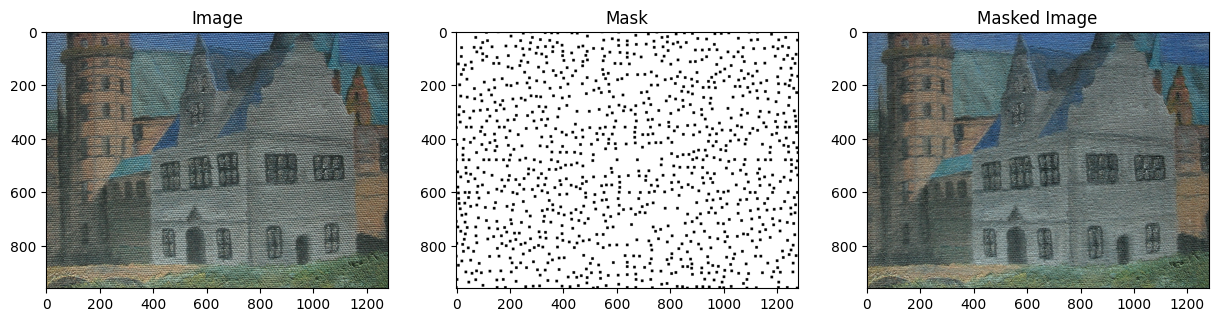

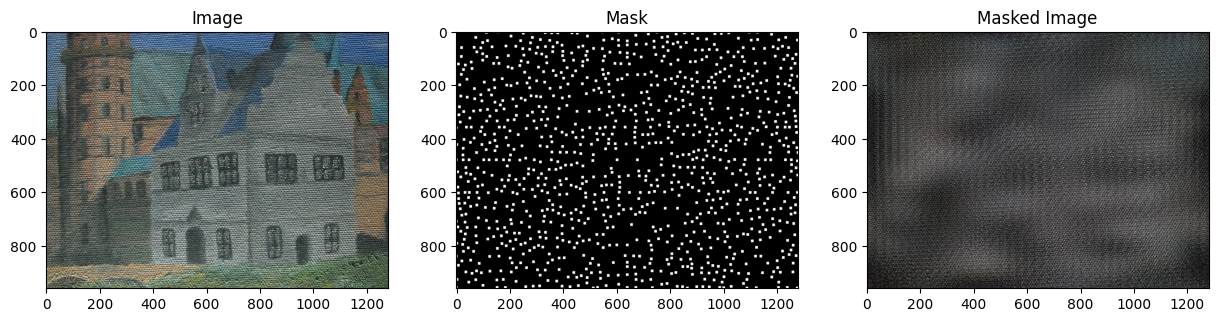

In [134]:
masking("185-8526_IMG.JPG", automate_mask("185-8526_IMG.JPG"))
masking("185-8526_IMG.JPG", automate_mask("185-8526_IMG.JPG", invert = True))

#### Additional Masking activity - Landers Grocery Bag

C:\Users\Julian Maypa\AppData\Local\Temp\ipykernel_6636\1660484072.py:60: RuntimeWarning: divide by zero encountered in log
  log_FAshifted = np.log(np.fft.fftshift(abs(FA)))


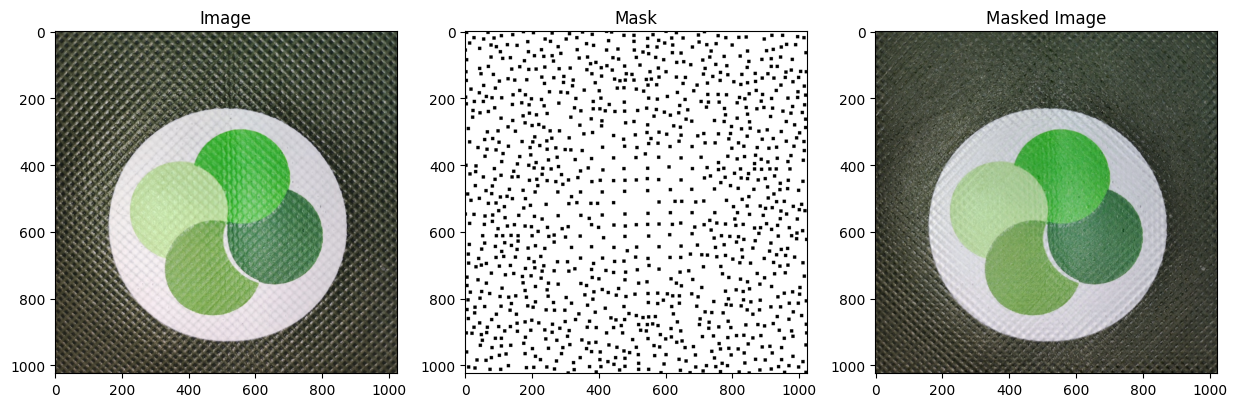

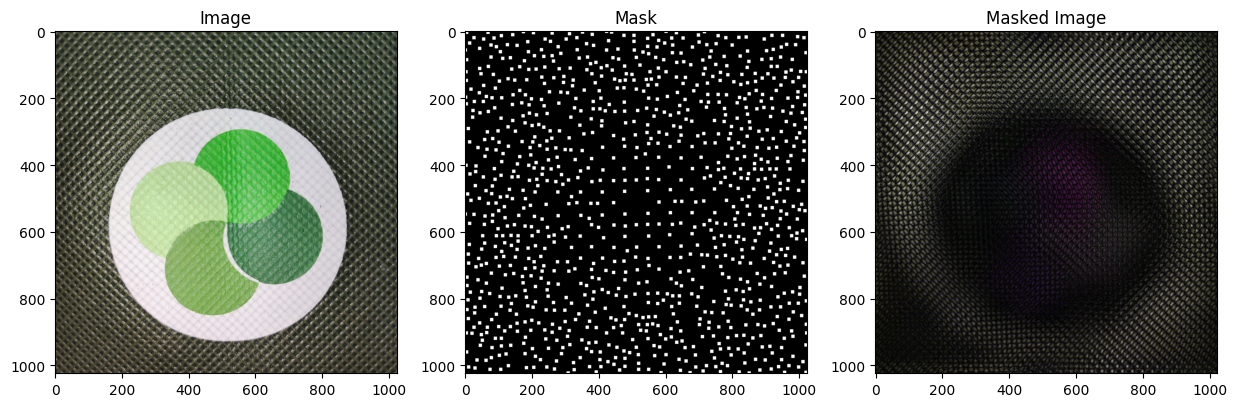

In [135]:
masking("grocery bag.jpg", automate_mask("grocery bag.jpg"))
masking("grocery bag.jpg", automate_mask("grocery bag.jpg", invert = True))

#### Fingerprints 
source: 
Sokoto Coventry Fingerprint Dataset (SOCOFing)


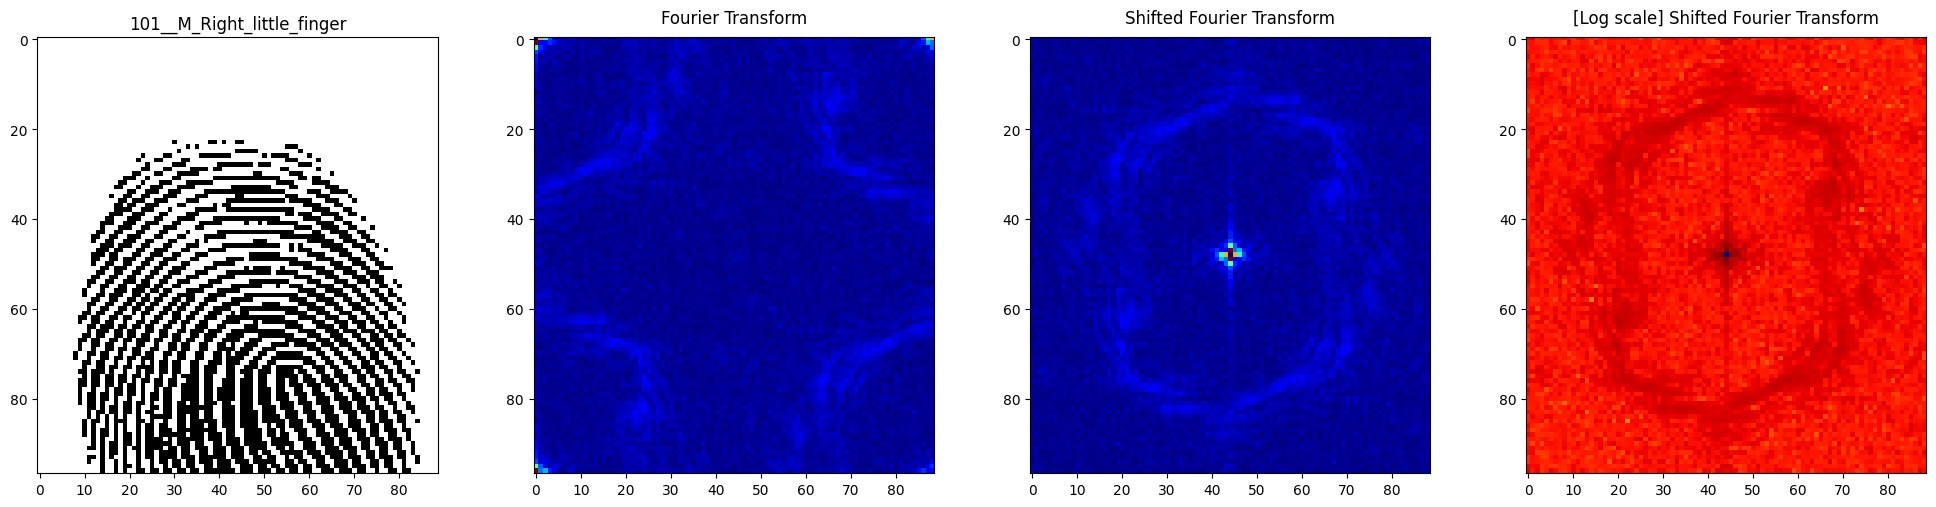

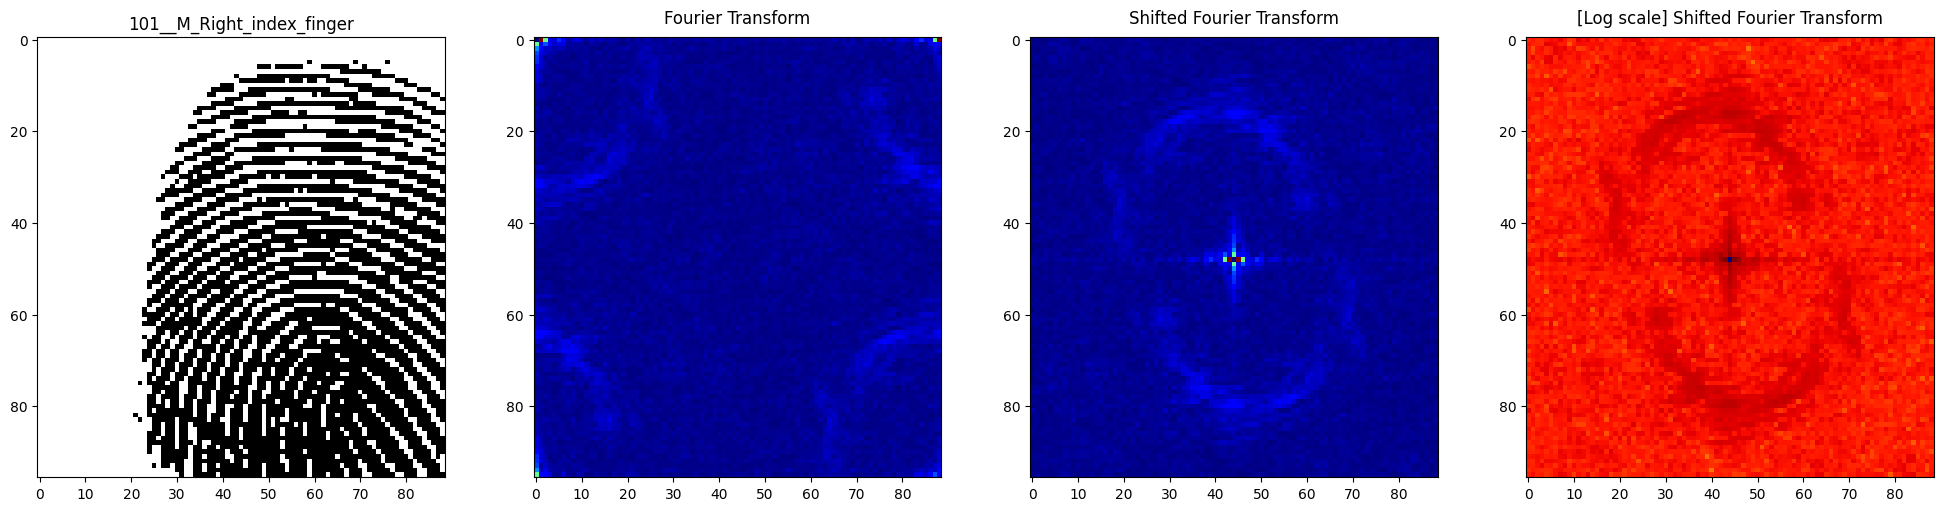

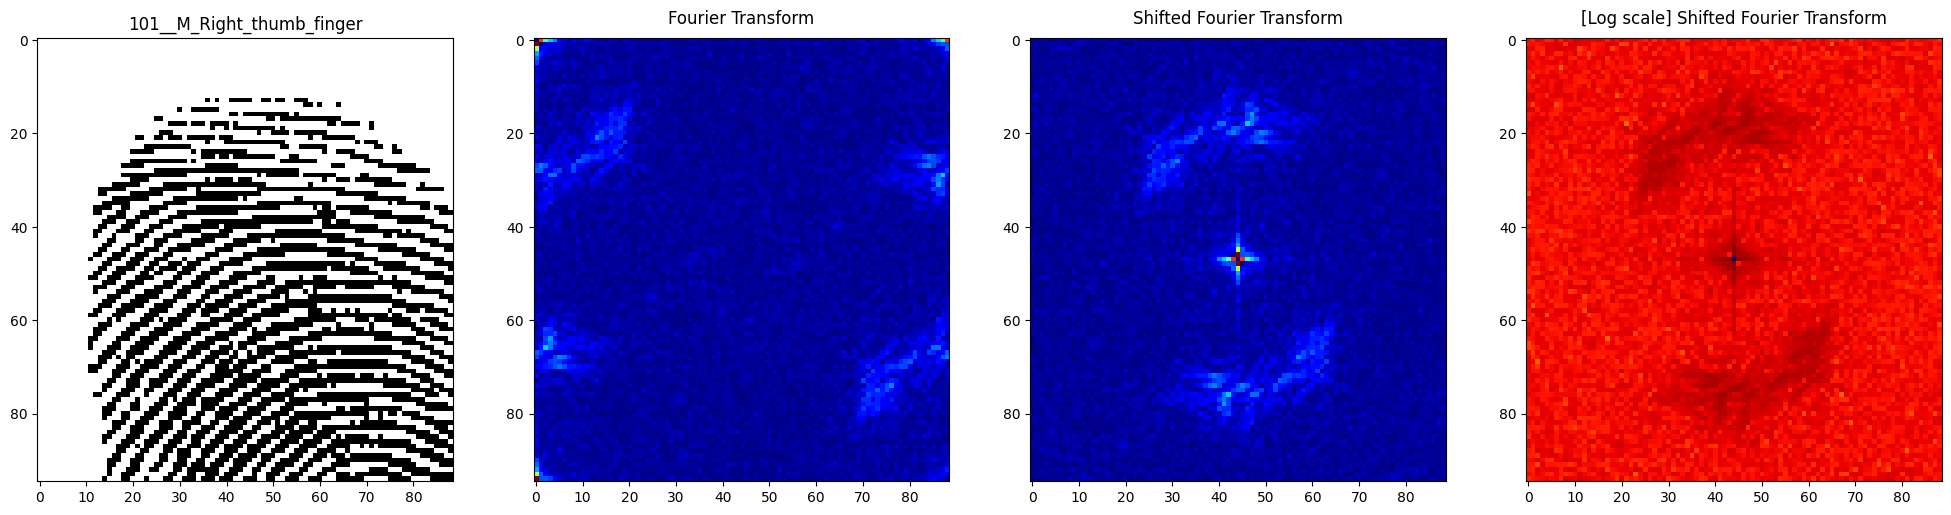

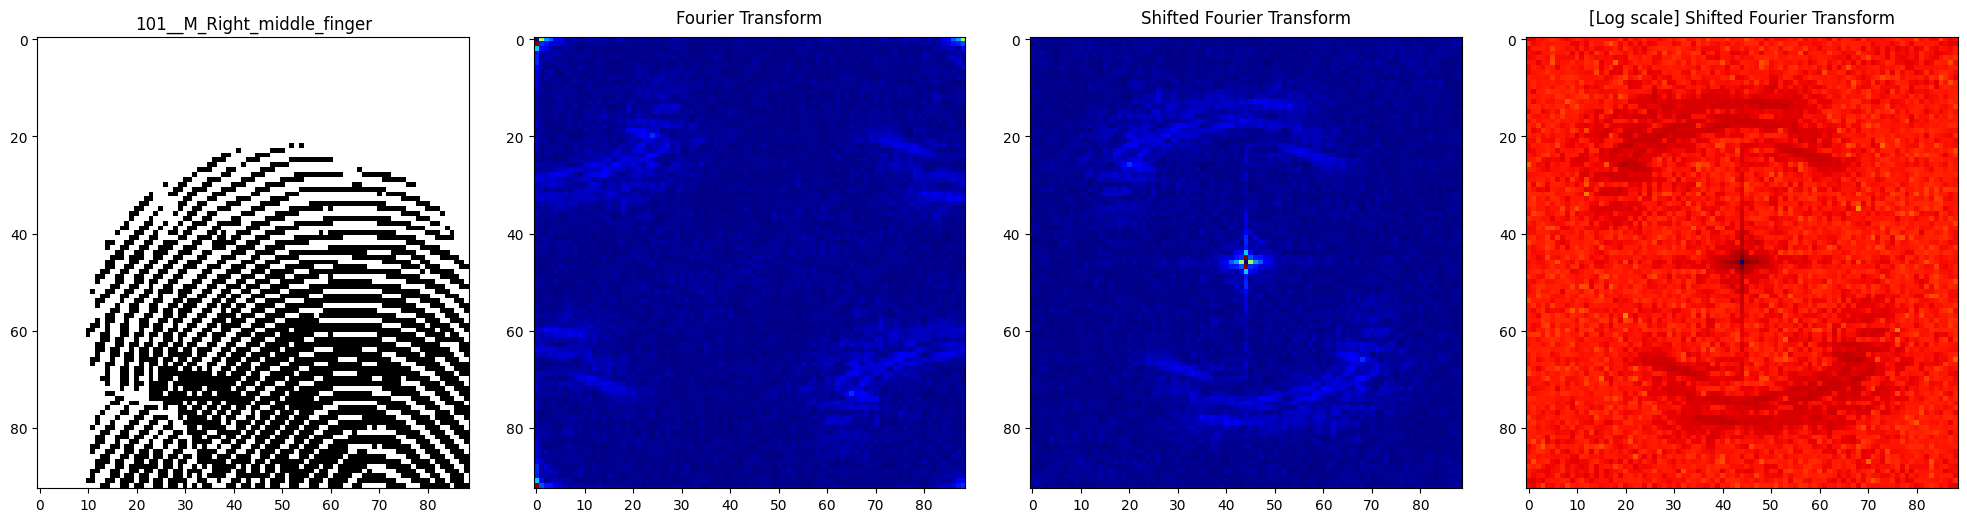

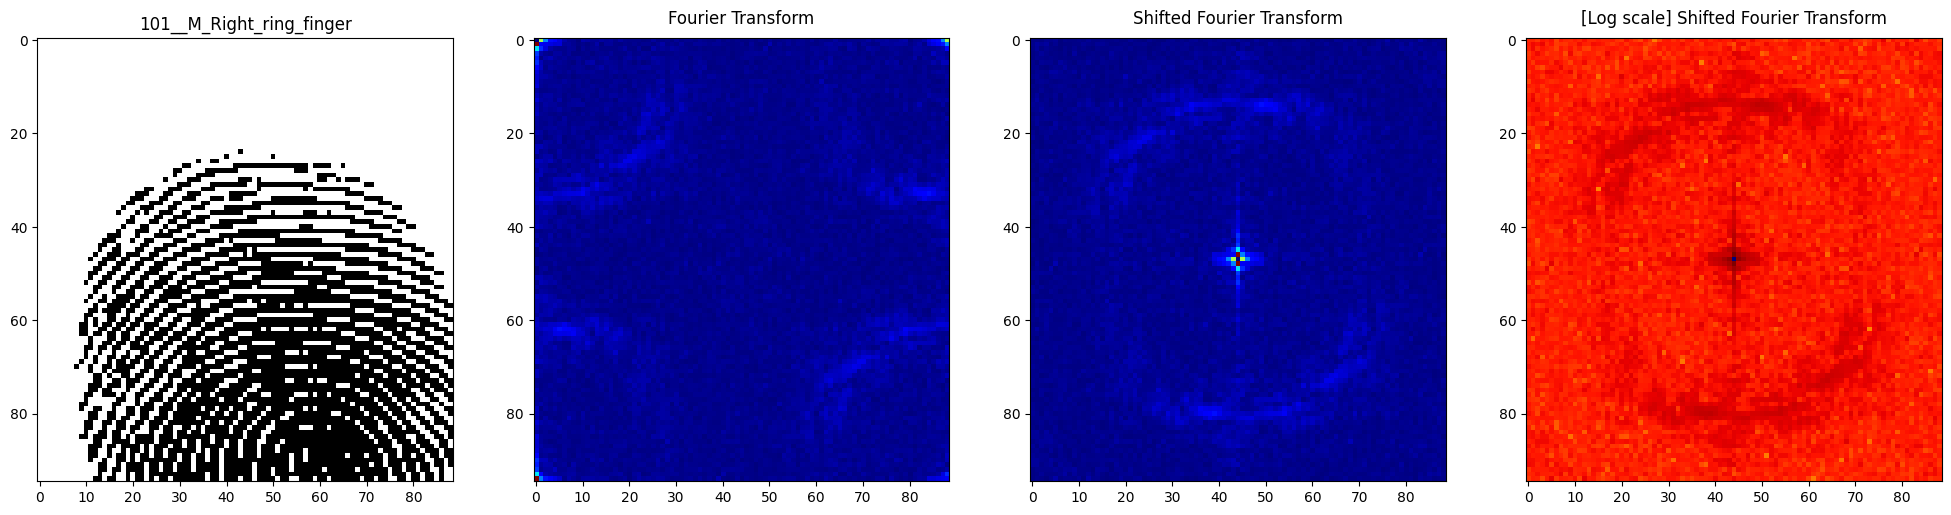

In [59]:
show_fft(convert_gs("101__M_Right_little_finger.dib", binary = True), "101__M_Right_little_finger", mean_center = True)
show_fft(convert_gs("101__M_Right_index_finger.dib", binary = True), "101__M_Right_index_finger", mean_center = True)
show_fft(convert_gs("101__M_Right_thumb_finger.dib", binary = True), "101__M_Right_thumb_finger", mean_center = True)
show_fft(convert_gs("101__M_Right_middle_finger.dib", binary = True), "101__M_Right_middle_finger", mean_center = True)
show_fft(convert_gs("101__M_Right_ring_finger.dib", binary = True), "101__M_Right_ring_finger", mean_center = True)

#### Fingerprints of the left index finger of different people

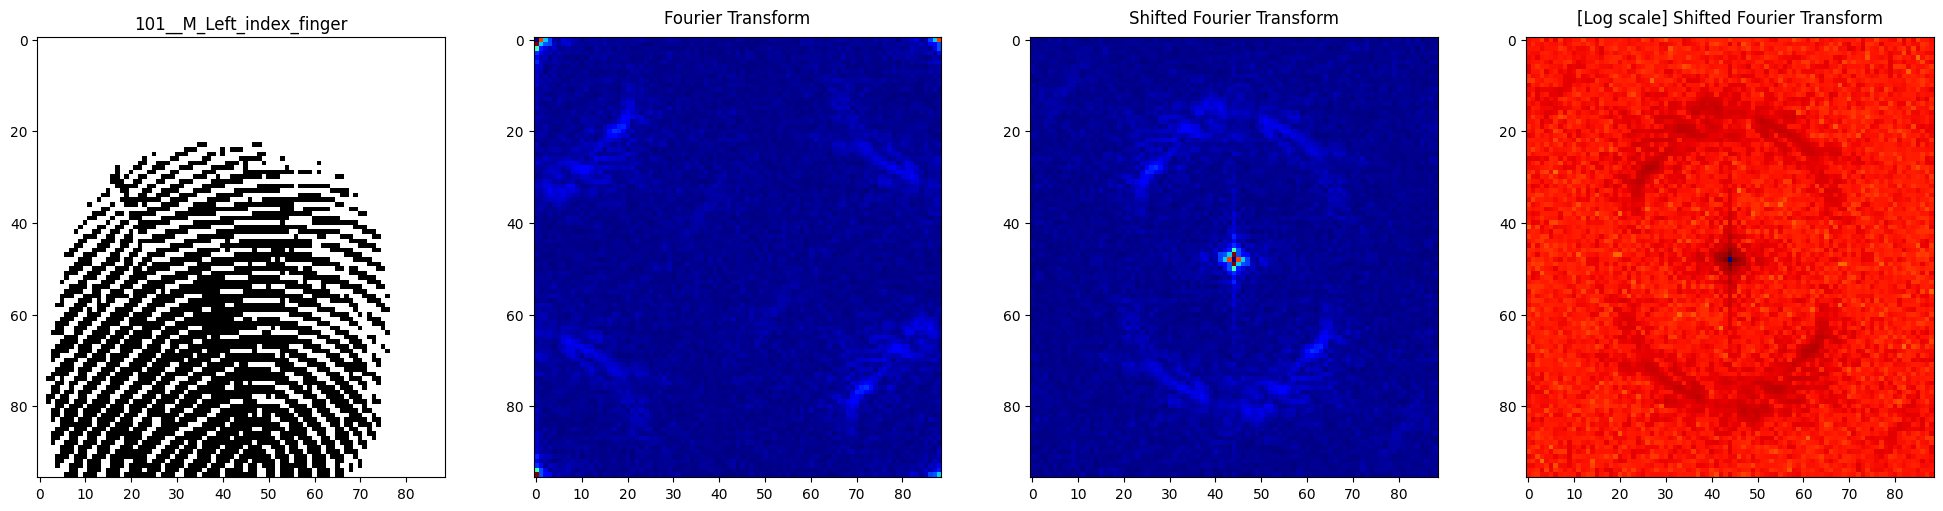

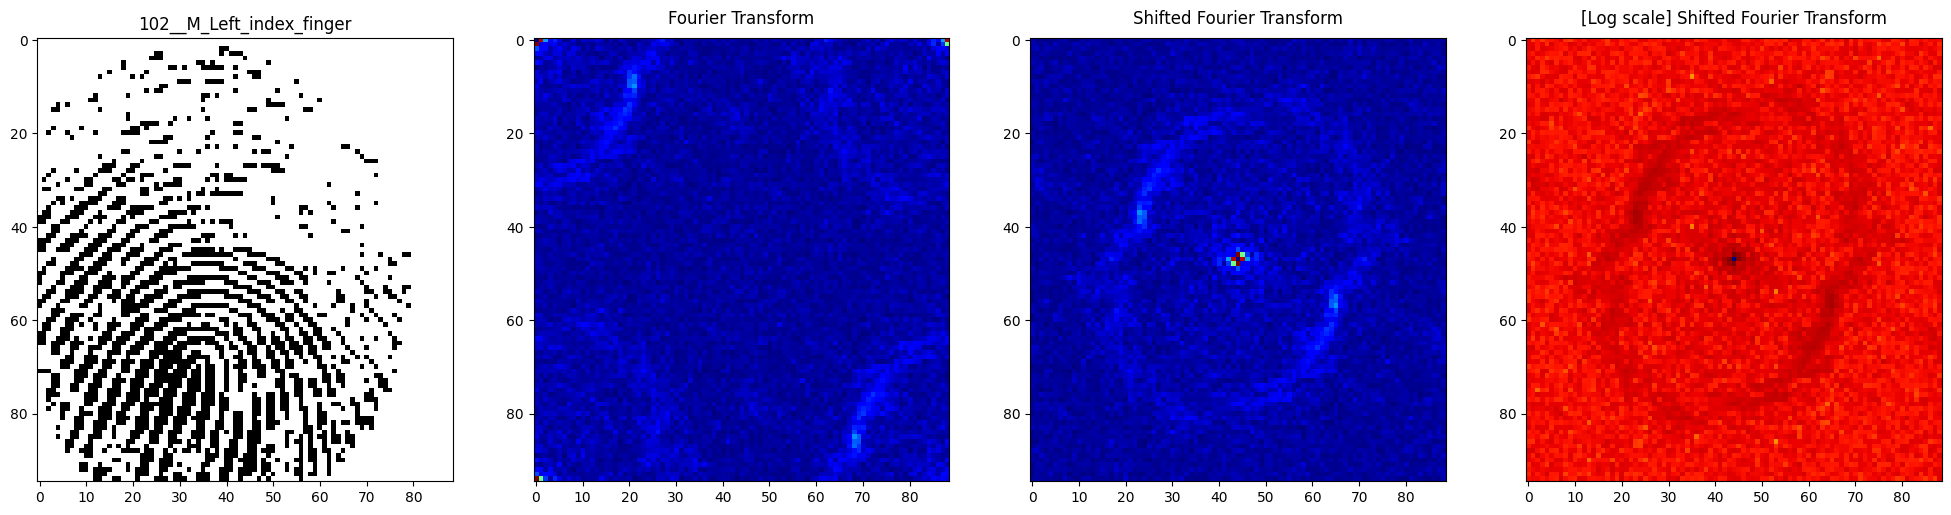

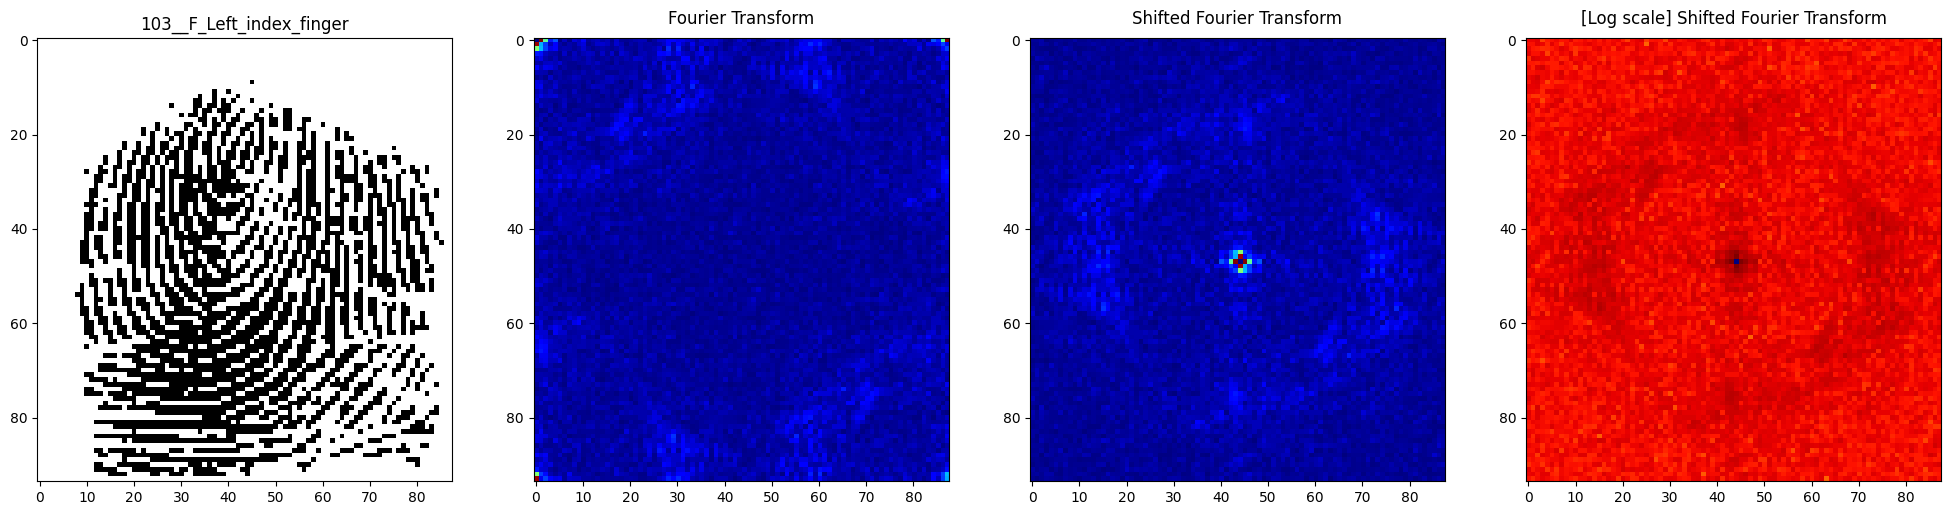

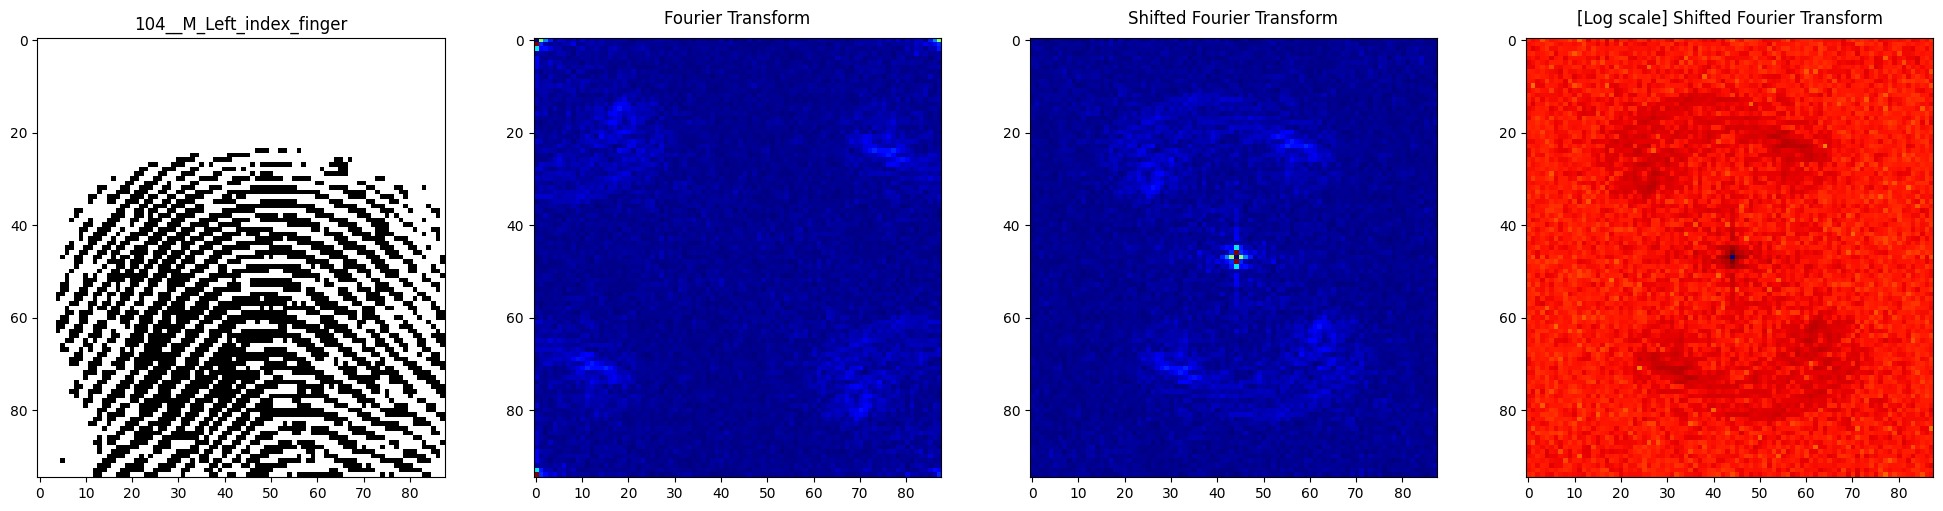

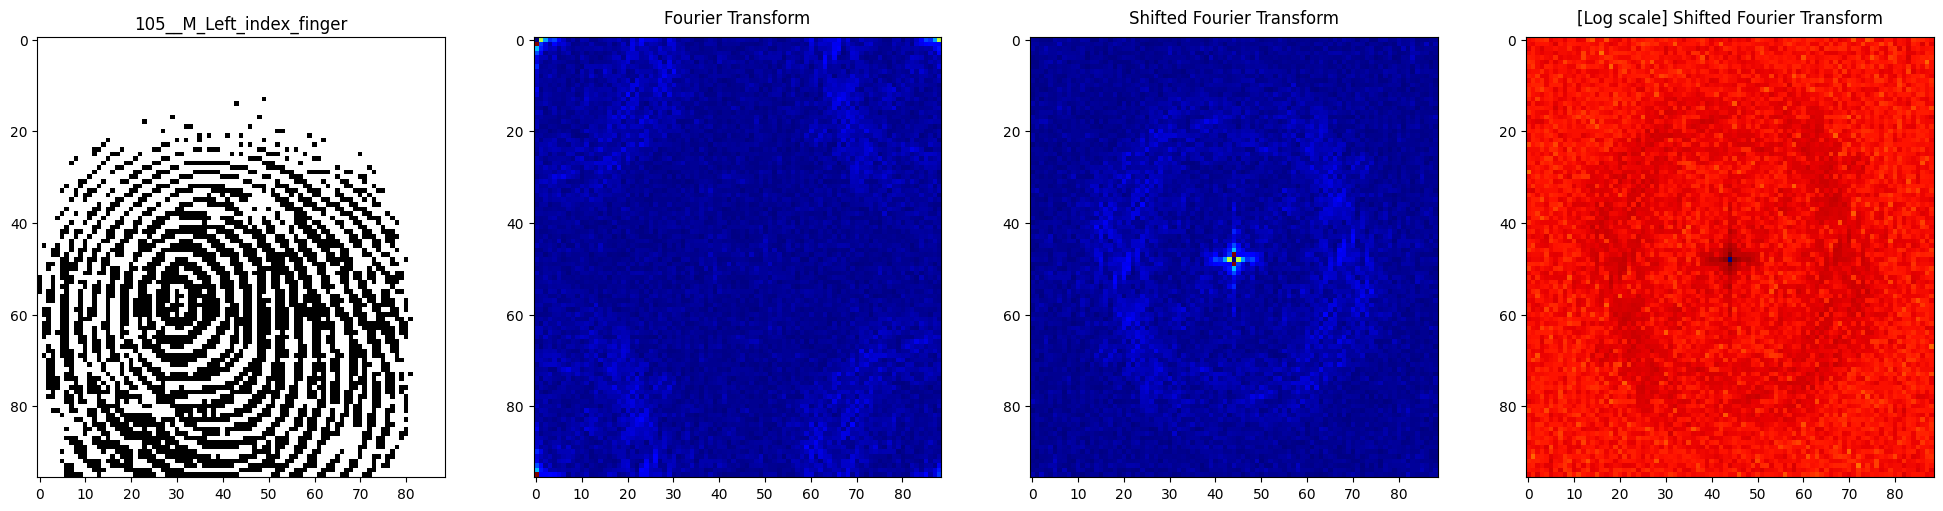

In [60]:
show_fft(convert_gs("101__M_Left_index_finger.dib", binary = True), "101__M_Left_index_finger", mean_center = True)
show_fft(convert_gs("102__M_Left_index_finger.dib", binary = True), "102__M_Left_index_finger", mean_center = True)
show_fft(convert_gs("103__F_Left_index_finger.dib", binary = True), "103__F_Left_index_finger", mean_center = True)
show_fft(convert_gs("104__M_Left_index_finger.dib", binary = True), "104__M_Left_index_finger", mean_center = True)
show_fft(convert_gs("105__M_Left_index_finger.dib", binary = True), "105__M_Left_index_finger", mean_center = True)

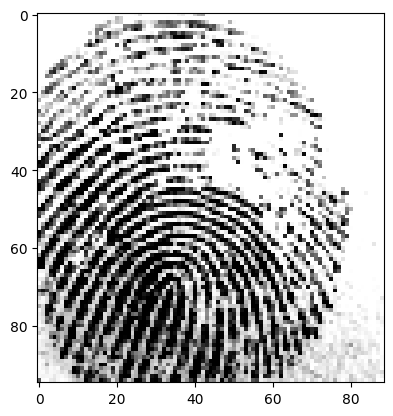

(95, 89)


In [66]:
image = Image.open(image_repository + "102__M_Left_index_finger.dib")
gs = np.array(image.convert('L'))

plt.imshow(gs, cmap = "gray")
plt.show()

print(gs.shape)